In [37]:
import ast
import os
import re
import sys
from io import StringIO

from langchain.callbacks import get_openai_callback
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_anthropic import ChatAnthropic

In [38]:
assert os.environ["ANTHROPIC_API_KEY"]

In [53]:
def setup_llm_chain():
    llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
    prompt_template = PromptTemplate(
        input_variables=["task"],
        template="あなたはPythonコードジェネレーターです。次のタスクに対するPythonコードのみを生成してください。説明は不要です：{task}",
    )
    return LLMChain(llm=llm, prompt=prompt_template)

In [54]:
def clean_code(code):
    code = re.sub(r"^```[\w\s]*\n|```$", "", code, flags=re.MULTILINE)
    code = code.replace("python\n", "", 1)
    code = code.strip()
    return code

In [55]:
def generate_code(chain, task):
    return chain.run(task)

In [56]:
def is_valid_and_safe_code(code):
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.Call):
                func = node.func
                if isinstance(func, ast.Attribute) and func.attr in [
                    "open",
                    "exec",
                    "eval",
                ]:
                    return False 
    except SyntaxError:
        print("Syntax Error")
        return False
    return True

In [57]:
def execute_code(code):
    if not is_valid_and_safe_code(code):
        return "Error: 生成されたコードは安全でないと判断されました。"

    old_stdout = sys.stdout
    redirected_output = sys.stdout = StringIO()

    try:
        exec(code)
        sys.stdout = old_stdout
        return redirected_output.getvalue()
    except Exception as e:
        sys.stdout = old_stdout
        return f"Error: {str(e)}"

In [58]:
def run_code_by_prompt(prompt):
    chain = setup_llm_chain()

    task = f"\n {prompt}: "

    print("\n生成中...")
    with get_openai_callback() as cb:
        generated_code = generate_code(chain, task)
        print(f"\nトークン使用量: {cb.total_tokens} （プロンプト: {cb.prompt_tokens}, 生成: {cb.completion_tokens}）")
        print(f"コスト: ${cb.total_cost:.5f}")

    cleaned_code = clean_code(generated_code)
            
    print("\n生成されたコード（クリーンアップ後）:")
    print(cleaned_code)

    print("\n実行結果:")
    result = execute_code(cleaned_code)
    print(result)


生成中...


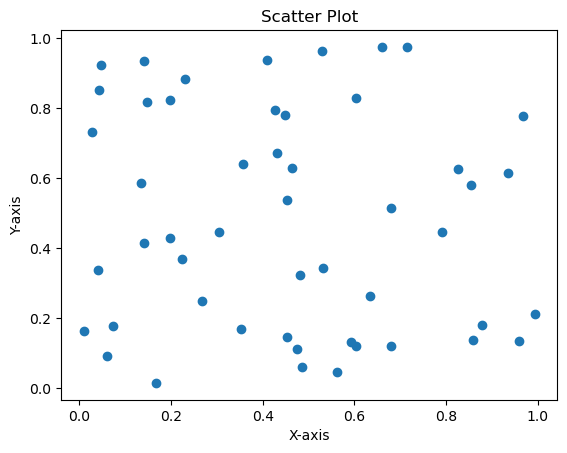


トークン使用量: 195 （プロンプト: 69, 生成: 126）
コスト: $0.00000

生成されたコード（クリーンアップ後）:
import matplotlib.pyplot as plt
import numpy as np

# ランダムなデータを生成
x = np.random.rand(50)
y = np.random.rand(50)

# 散布図を作成
plt.scatter(x, y)

# グラフのタイトルと軸ラベルを設定
plt.title('Scatter Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# グラフを表示
plt.show()

実行結果:



In [59]:
run_code_by_prompt(
    "散布図を書くコードを実行して。"
)